In [81]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [82]:
import matplotlib.pyplot as plt
import math
import numpy as np

In [83]:
from tqdm import tqdm

In [84]:
%%cython -+ 
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable
    
cdef void init_spins(long[::1] spins, RndmWrapper rndm): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js, RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2):
    
    for i in range(L1*L2):
        Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
        Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
        Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
        Js[i, (i + L2) % (L1*L2)] = J
        Js[i, (i // L2) * L2 + (i - 1) % L2] = J
        Js[i, (i - L2) % (L1*L2)] = J
    return
        

def simulate_en(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int num_therm, int seed, int rseed = 1234):


    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        #int num_therm = int(1e4)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i, sweeps = 0
        double Z = 0., av_en = 0
        enes = []
        mesurements = []
        
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable ene = RealObservable()

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
        enes.append(energy(spins, neighbors, Js))
        sweeps += 1

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
        enes.append(energy(spins, neighbors, Js))
        sweeps += 1
            
        Z += 1
        av_en += energy(spins, neighbors, Js)
        ene.add_measurement(energy(spins, neighbors, Js))
        mesurements.append(sweeps)
     
    return (av_en/Z , ene.errorbar, enes, mesurements)

def simulate_mag(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int num_therm, int seed, int rseed = 1234):


    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        #int num_therm = int(1e4)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i, sweeps = 0
        double Z = 0., av_magn = 0
        mags = []
        mesurements = []
        
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable m = RealObservable()

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
        mags.append(magn*magn)
        sweeps += 1

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
        mags.append(magn*magn)
        sweeps += 1
            
        Z += 1
        av_magn += magn**2
        m.add_measurement(magn**2)
        mesurements.append(sweeps)
     
    return (av_magn/Z , m.errorbar, mags, mesurements)

Убедимся, что количество шагов термализации 100 * L^2 достаточно для достижения равновесия при необходимых размерах.


Обычно я беру 10^5 или 10^4 для таких резмеров. Сейчас получается 4 * 10^4 для 20, 1.6 * 10^5 для 40, 10^4 для 10.


In [5]:
import random

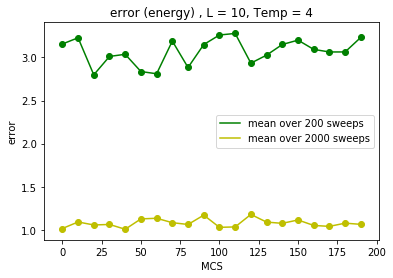

In [405]:
L = 10
T = 4
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate_en(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate_en(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += np.abs(error * 100 / av_en)/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

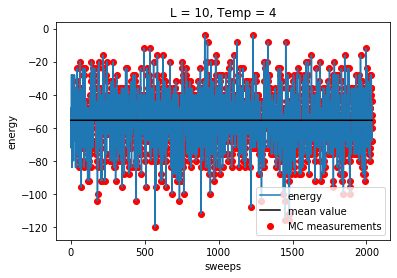

In [406]:
num_th = 40
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

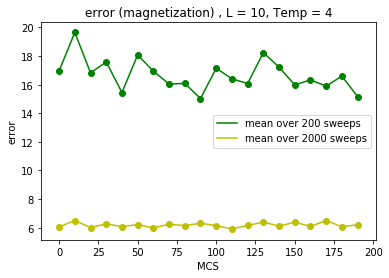

In [7]:
L = 10
T = 4
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += np.abs(error * 100 / av_mag)/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += np.abs(error * 100 / av_mag)/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

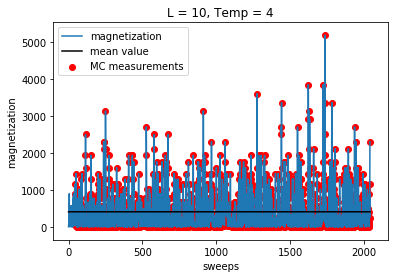

In [8]:
num_th = 40
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

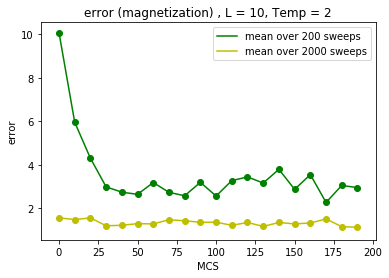

In [9]:
L = 10
T = 2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += np.abs(error * 100 / av_mag)/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += np.abs(error * 100 / av_mag)/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

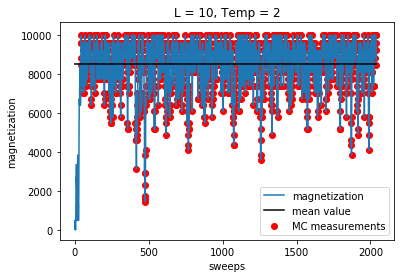

In [10]:
num_th = 40
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

In [101]:
L = 20
T = 0.5
num_sweeps = 10000
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))


num_th = 400
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

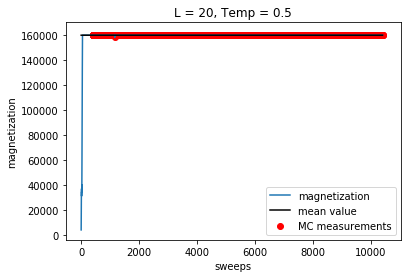

In [102]:
plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

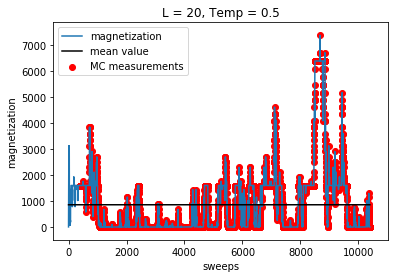

In [100]:
plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

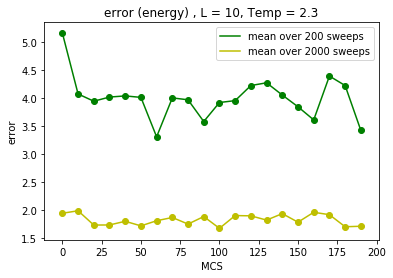

In [410]:
L = 10
T = 2.3
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += np.abs(error * 100 / av_en)/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

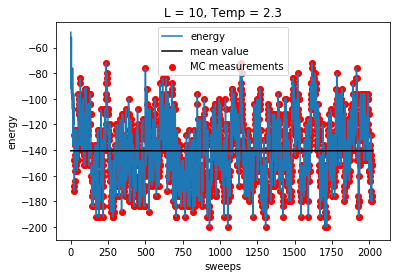

In [411]:
num_th = 20
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

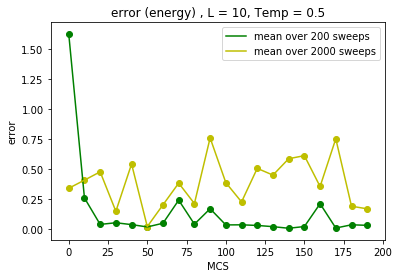

In [408]:
L = 10
T = 0.5
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += np.abs(error * 100 / av_en)/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

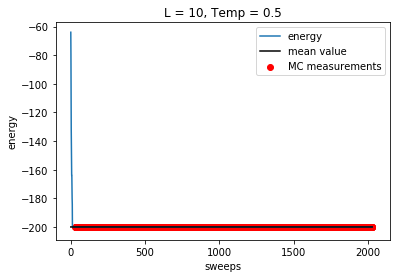

In [409]:
num_th = 30
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

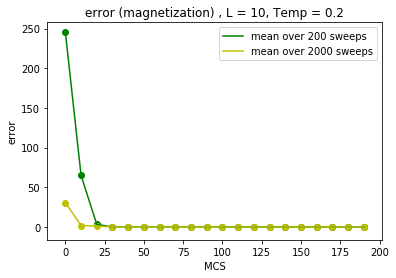

In [13]:
L = 10
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors1[i] += error/N
        eq_times[i] += num_th/N
        
num_sweeps = 2000
        
for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors2[i] += error/N    
        
plt.scatter(eq_times, errors1, c = 'g')
plt.plot(eq_times, errors1, c = 'g', label = 'mean over 200 sweeps')
plt.scatter(eq_times, errors2, c = 'y')
plt.plot(eq_times, errors2, c = 'y', label = 'mean over 2000 sweeps')
plt.xlabel('MCS')
plt.ylabel('error')
plt.legend()
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

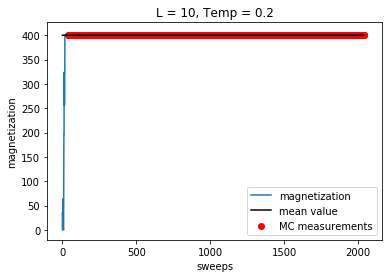

In [79]:
L = 10
T = 0.2
num_sweeps = 2000
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(20)
errors1 = np.zeros( int(num_th_max/step))
errors2 = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

num_th = 40
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

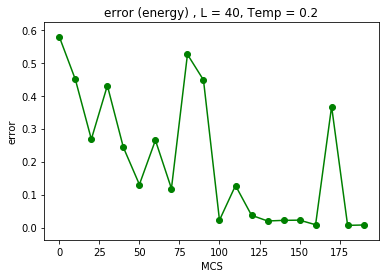

In [374]:
L = 40
T = 0.2
num_sweeps = 2000
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

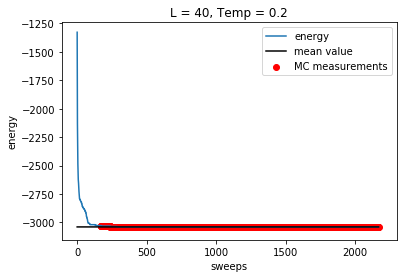

In [371]:
num_th = 170
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

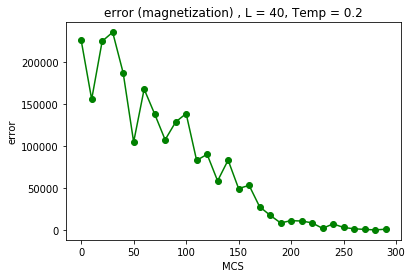

In [19]:
L = 40
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(300)
step = int(10)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += error/N
        eq_times[i] += num_th/N
        
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

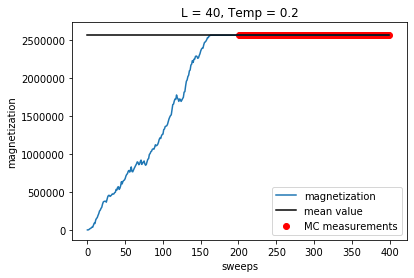

In [21]:
num_th = 200
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

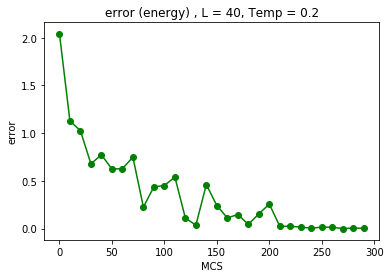

In [390]:
L = 40
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(300)
step = int(10)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

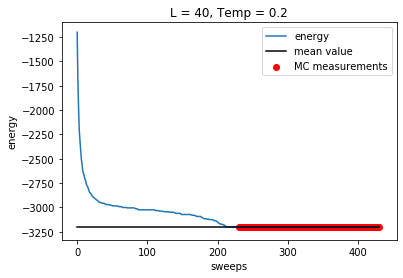

In [393]:
num_th = 230
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

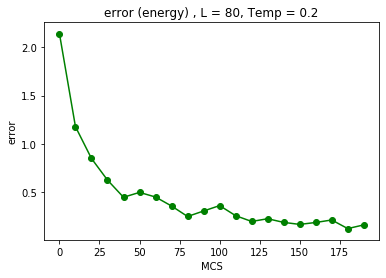

In [397]:
L = 80
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

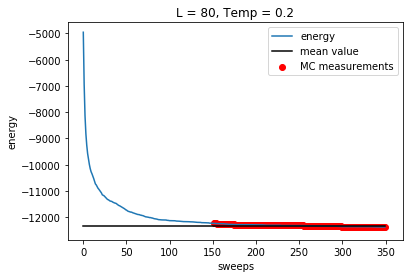

In [367]:
num_th = 150
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

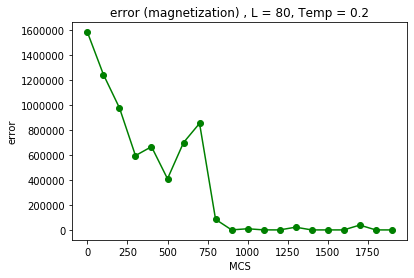

In [30]:
L = 80
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(2000)
step = int(100)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += error/N
        eq_times[i] += num_th/N
        
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

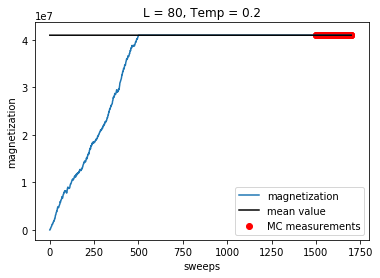

In [37]:
num_th = 1500
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

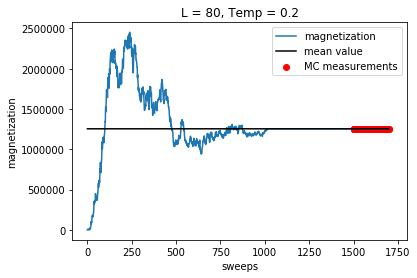

In [36]:
num_th = 1500
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

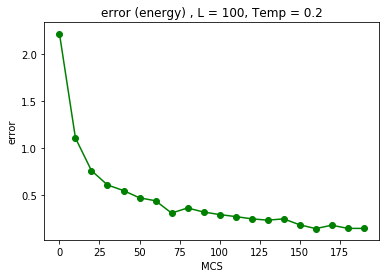

In [401]:
L = 100
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(200)
step = int(10)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += np.abs(error * 100 / av_en)/N
        eq_times[i] += num_th/N
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (energy) , L = {L}, Temp = {T}')
plt.show()

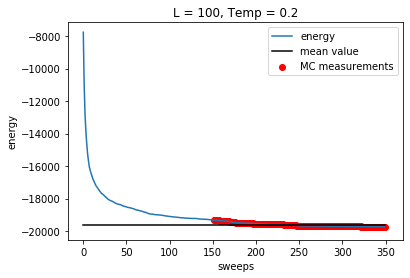

In [369]:
num_th = 150
seed = random.randint(1,2000)
av_en, error, energy, steps = simulate(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [energy[i] for i in steps[:-1]]

plt.plot(times, energy, label = 'energy')
plt.plot(times, [av_en]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('energy')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

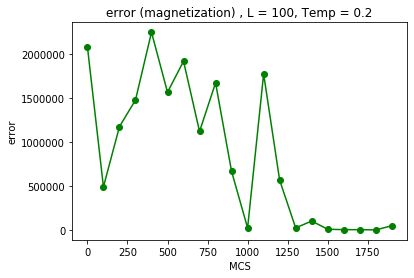

In [38]:
L = 100
T = 0.2
num_sweeps = 200
J = 1
Jd = 0

num_th_max = int(2000)
step = int(100)
N = int(5)
errors = np.zeros( int(num_th_max/step))
eq_times = np.zeros(int(num_th_max/step))

for _ in range(N):
    for i, num_th in enumerate(np.arange(0,num_th_max,step)):
        seed = random.randint(1,2000)
        av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)
        errors[i] += error/N
        eq_times[i] += num_th/N
        
        
plt.scatter(eq_times, errors, c = 'g')
plt.plot(eq_times, errors, c = 'g')
plt.xlabel('MCS')
plt.ylabel('error')
plt.title(f'error (magnetization) , L = {L}, Temp = {T}')
plt.show()

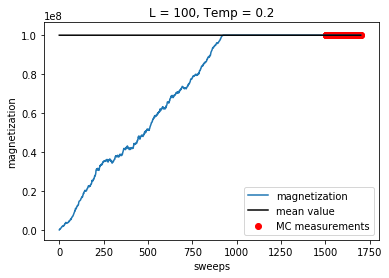

In [40]:
num_th = 1500
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()

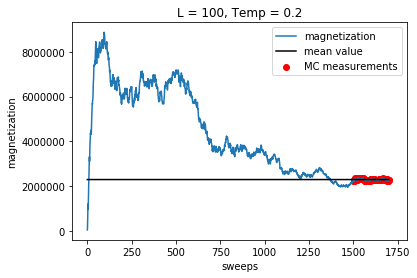

In [58]:
num_th = 1500
seed = random.randint(1,2000)
av_mag, error, mag, steps = simulate_mag(L, T, J, Jd, num_sweeps, num_th, seed)

time = num_th + num_sweeps
times = np.arange(0,time,1)
mes = [mag[i] for i in steps[:-1]]

plt.plot(times, mag, label = 'magnetization')
plt.plot(times, [av_mag]*time, c = 'black', label = 'mean value')
plt.scatter(steps[:-1], mes, c = 'r', label = 'MC measurements')
plt.xlabel('sweeps')
plt.ylabel('magnetization')
plt.legend()
plt.title(f'L = {L}, Temp = {T}')
plt.show()